In [2]:
import numpy as np
from PIL import Image
import sys, os
import matplotlib.pyplot as plt
from utils import *
import pickle, random, time
import theano as T
theano.config.floatX = 'float32'
%matplotlib inline

# Local Learning Recurrent ZCA Analysis of MNIST

### One layer linear network with inter-neurons recovers whitened primary components of the covariance matrix

The MNIST image is represented by a vetcor 

$$x \in \Re^d$$

$$L=trace(-X^TXY^TY + Y^TY + Y^TYZ^TZ - Z^TZ)$$

The loss is a function of the input, hidden neurons, and a set of inhibitory interneurons whose purpose is to equalize the activations of the hidden neurons.

$$y_{t+1}=x^{T}W_{xy}-y_{t}^TW_{yy,i\neq j} - z^T W_{zy}$$
$$z_{t+1}=y^{T}W_{yz}$$

The hidden layer activation, y, has three inputs: the input from the data, lateral inhibitory connections from the local layer, and a signal from inhibitory interneurons. The interneuron activation is determined by the hidden layer activations.

An expectation-maximiztion algorithm is performed where the dynamics of the system are allowed to converge to a likely state and then a gradient step is taken down the loss function. Here the next frame is calculated using aa scalar constant, fr.

$$fr=0.1$$

$$\hat{y}=(1-fr) y_{t-1} + y_{t}fr$$

$$\frac{\delta L}{\delta W_{xy}}=x^{T}y-y^{2}W_{yx}$$

$$\frac{\delta L}{\delta W_{yy}}=(1+\gamma)y^{T}y-y^{2}W_{yy}$$
$$\frac{\delta L}{\delta W_{yz}}=y^{T}z-y^{2}W_{yz}$$
$$\frac{\delta L}{\delta W_{zy}}=z^{T}y-z^{2}W_{zy}$$

Here, $\gamma$, controls the degree of lateral inhibition.

In [3]:
# load data set
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = \
    np.load('mnist.pkl')
train_x, train_y, valid_x, valid_y, test_x, test_y = [theano.shared(s) for s in 
                                                      [train_x, train_y, valid_x, valid_y, test_x, test_y]]
#train_x = np.nan_to_num((train_x - np.mean(train_x, axis=0))/np.std(train_x, axis=0))

In [4]:
class ZCANet:
    def __init__(self):
            self.params = {}
            self.hyper_params = {}
            self.stats = {}
            self.fig_stats = {}
            self.exps = []
            
            
    def run_exp(self, nsamples=50000, nx=train_x.get_value().shape[1], ny=16, nz=16, tol=10**-3, frames=100, fr=0.1,
                gamma=1, alpha=1, beta=1, learning_rule=norm_update, lr=10**-3, exp_name=None):
        
        if exp_name == None:
            exp_name = 'zcanet_ny_' + str(ny) + '_gamma_' + str(gamma) + '_learning_rule_' + learning_rule.__name__
        plotres = nsamples/100 if nsamples >= 100 else 1
        
        # init weights
        w_yx = T.shared(rand_ortho(nx, ny))
        w_yy = T.shared(rand_ortho(ny, ny))
        w_yz = T.shared(rand_ortho(ny,nz))
        w_zy = T.shared(rand_ortho(nz,ny))

        #init vars
        y = T.shared(np.random.rand(ny))
        z = T.shared(np.random.rand(nz))
        
        #init dw
        dw_yx = T.shared(np.zeros((nx, ny)))
        dw_yy = T.shared(np.zeros((ny, ny)))
        dw_yz = T.shared(np.zeros((ny, nz)))
        dw_zy = T.shared(np.zeros((nz, ny)))
        
        #misc vars
        y_mask = T.shared(np.ones((ny, ny))-np.eye(ny))
        i = T.tensor.iscalar()
        x = T.tensor.fvector()
        
        #expectation vars and funcs
        yt = x.dot(w_yx) - y.dot(w_yy*y_mask) - z.dot(w_zy)
        zt = y.dot(w_yz)
        ex_updates = OrderedDict({y: (1-fr)*y + fr*yt,
                                  z: (1-fr)*z + fr*zt})
        expectation = T.function([i], [yt, zt], givens={x: train_x[i]}, updates=ex_updates)

        #maximization vars and funcs
        dw_yx = T.tensor.outer(x, y) - alpha*(y**2)*w_yx
        dw_yy = (gamma)*T.tensor.outer(y, y) - alpha*(y**2)*w_yy
        dw_yz = T.tensor.outer(y, z) - alpha*(y**2)*w_yz
        dw_zy = T.tensor.outer(z, y) - beta*(z**2)*w_zy
        max_updates = learning_rule({w_yx: dw_yx,
                                     w_yy: dw_yy,
                                     w_yz: dw_yz,
                                     w_zy: dw_zy}, lr)
        maximization = T.function([i], [dw_yx, dw_yy, dw_yz, dw_zy], givens={x: train_x[i]}, updates=max_updates)

        #run em
        steps = []
        deltas = []
        Y = []
        Z = []
        diffs = []
        diffsm = []
        for sample in range(nsamples):

            #expectation
            step = 0
            for f in range(frames):
                step += 1
                yex, zex = expectation(sample)
                #if step%10==0:
                #    print(np.mean(yex))
                #diff = np.sum((y.get_value()-yex)**2)
                #diffm = np.mean((y.get_value()-yex)**2)
                if np.sum((y.get_value()-yex)**2) < tol:
                    break

            #maximization
            if sample%plotres == 0:
                deltas += [maximization(sample)[0]]
                # print(np.linalg.norm(deltas[sample], axis=0))
                steps+=[step]
                Y += [y.get_value()]
                Z += [z.get_value()]
                #diffs += [diff]
                #diffsm += [diffm]
            else:
                maximization(sample)
        
        #save exp params        
        self.params[exp_name] = {'w_yx': w_yx.get_value(), 'w_yy': w_yy.get_value(),
                                 'w_yz': w_yz.get_value(), 'w_zy': w_zy.get_value()}
        
        #save stats
        deltas = np.asarray(deltas)
        self.stats[exp_name] = {'Frame Steps': steps, 'dw norm': deltas, 'y': Y, 'z': Z}#, ('diffs', diffs), ('diffms', diffsm))
        
        self.hyper_params[exp_name] = {'lr': lr, 'nx': nx, 'ny': ny, 'nz': nz, 'nsamples': nsamples, 'fr': fr}
        if exp_name not in self.exps:
            self.exps += [exp_name]
        
    def plots(self, exp=None, save_fig=False, path='net_plots/'):
        if exp == None:
            exps = self.exps
        else:
            exps = [exp]
            
        for exp in exps:
            #plot fitlers
            filters = self.params[exp]['w_yx']
            nx = filters.shape[0]
            ny = filters.shape[1]
            rc=int(np.sqrt(self.hyper_params[exp]['ny']))
            fig, ax = plt.subplots(rc,rc, figsize=(10,10))
            fig.suptitle('Filters: ' + exp)
            for i in range(rc):
                for j in range(rc):
                    ax[i][j].imshow(filters.T[i*rc+j].reshape(nx**0.5, nx**0.5), cmap=plt.cm.gray)
            if save_fig:
                fig.savefig(path + '{}_filters.png'.format(exp))
                plt.close(fig)
                
            #plot param inner product matrix
            params = self.params[exp].values()
            fig, ax = plt.subplots(1, len(params), figsize=(10,10))
            fig.suptitle('Inner Product Matrix: ' + exp)
            for mat, param in enumerate(params):
                ax[mat].imshow(param.T.dot(param), cmap=plt.cm.gray)
            if save_fig:
                fig.savefig(path + '{}_mat.png'.format(exp))
                plt.close(fig)
                
            #plot stats
            fig = plt.figure(figsize=(10,5))
            fig.suptitle('Stats: ' + exp)
            stats= self.stats[exp]
            for num, stat in enumerate(stats):
                num += 1
                name, stat = stat, stats[stat]
                stat = np.asarray(stat)
                if len(stat.shape) > 2:
                    for vec in range(ny):
                        fig.add_subplot(1, len(stats), num).plot(np.linalg.norm(stat[:,vec],axis=1))
                else:
                    fig.add_subplot(1, len(stats), num).plot(stat)

                fig.add_subplot(1, len(stats), num).set_title(name)   
                
            if save_fig:
                fig.savefig(path + '{}_stats.png'.format(exp))
                plt.close(fig)
            
    

In [5]:
net = ZCANet()

In [6]:
gammas = [1]#[0.1,1,10]
alphas = [1]#[0.1,1,10]
betas = [1]#[0.1,1,10]
n = len(gammas)*len(alphas)*len(betas)
begin = time.time()
c = 0
for g in gammas:
    for a in alphas:
        for b in betas:
            c += 1
            print(g,a,b)
            start = time.time()
            net.run_exp(nsamples=5000, gamma=g, alpha=a, beta=b, exp_name='g={} a={} b={}'.format(g,a,b), tol=10**-4)
            end = time.time()
            dur = end - start
            avgt = (end - begin)/float(c)
            tr = float(n-c)*avgt
            print('remaining est: {} sec avgt: {} sec'.format(tr, avgt))  

(1, 1, 1)
remaining est: 0.0 sec avgt: 71.4651851654 sec


/home/cbybee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:117: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


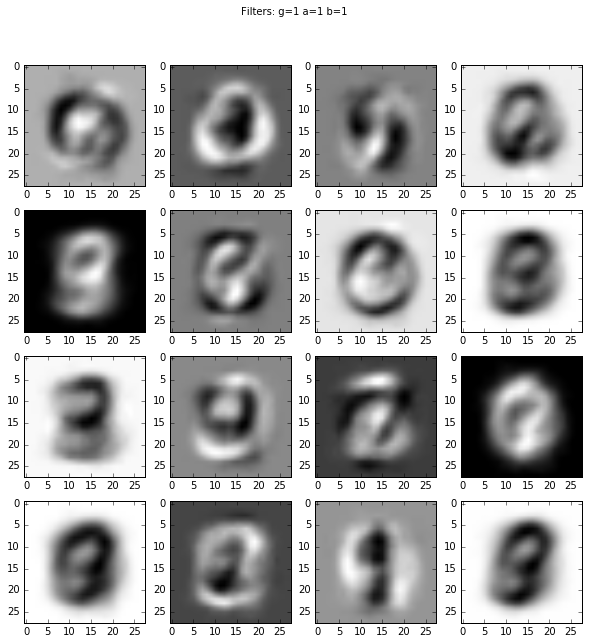

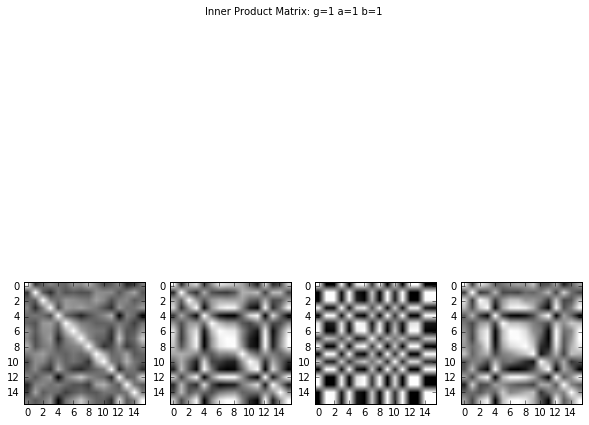

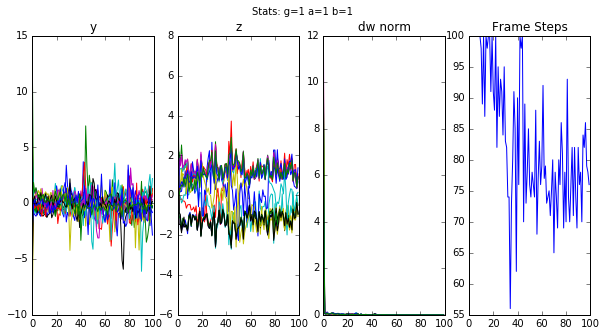

In [7]:
net.plots()

Consider pcanet with gamma equal to one.

In [9]:
exp = net.exps[0]
stats = net.stats[exp]
params = net.params[exp]
hyper_params = net.hyper_params[exp]

Mapping examples through the network and then inverting the signals is analogous to projecting examples onto the top nh primary components. 

/home/cbybee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:41: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cbybee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:46: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cbybee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


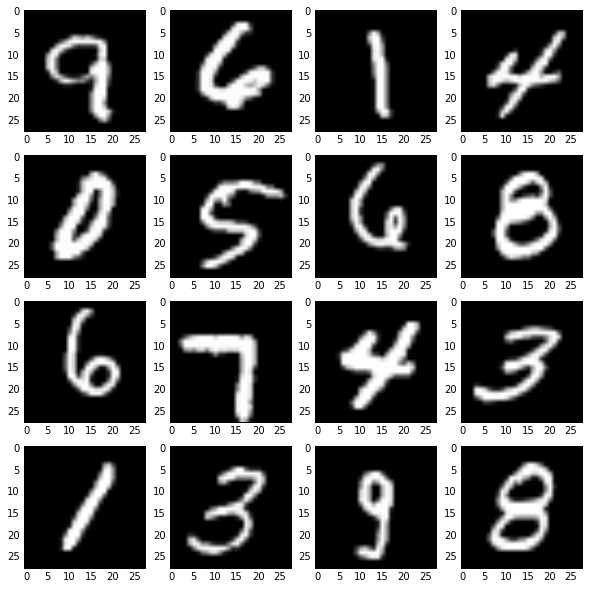

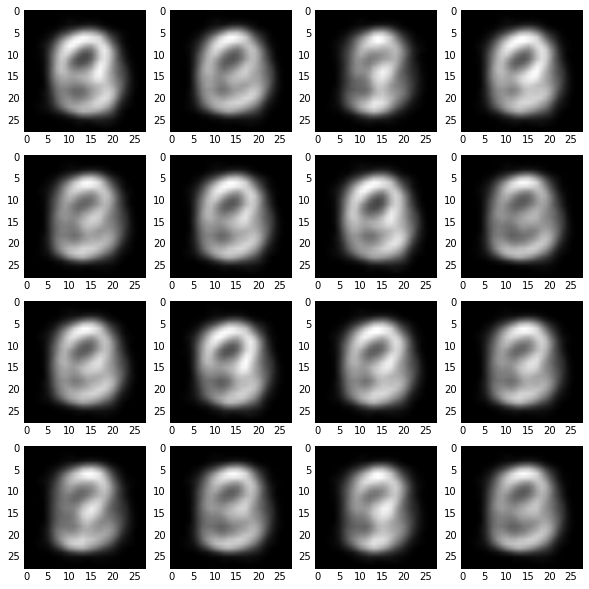

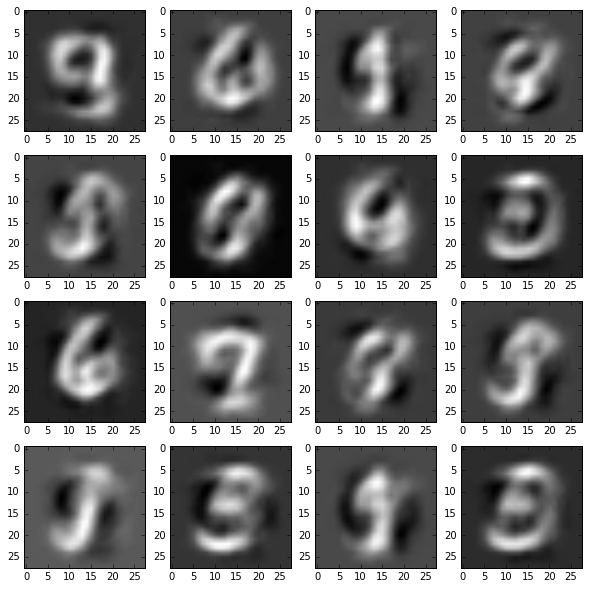

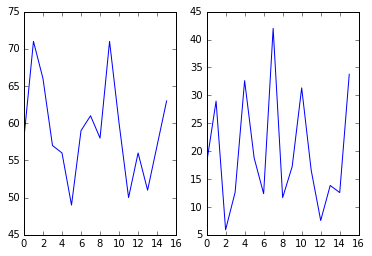

In [10]:
w_yx, w_yy, w_yz, w_zy = params['w_yx'], params['w_yy'], params['w_yz'], params['w_zy'] # get model parameters
nex = hyper_params['ny'] # choose a number of examples to plot
ny, nx, nz = hyper_params['ny'], hyper_params['nx'], hyper_params['nz']
examples = np.asarray(random.sample(train_x.get_value(), nex)) # randomly select samples
ex1y = examples.dot(w_yx) # compute example hidden layer activation "encode"
ex1 = ex1y.dot(w_yx.T) # invert activations "decode"
ex2 = []

# Run EM and allow y to settle before inverting.
steps = []
ex2y = []
frames = 100
tol = 10**-3
fr = 0.1
y_mask = np.ones((ny, ny))-np.eye(ny)
y = np.random.rand(ny)
z = np.random.rand(nz)
for ex, x in enumerate(examples):
        #expectation
        step=0
        for f in range(frames):
            y1 = x.dot(w_yx) - y.dot(w_yy*y_mask) - z.dot(w_zy)
            z1 = y.dot(w_yz)
            z = (1-fr)*z + fr*z1
            y = (1-fr)*y + fr*(y1)
            step+=1
            if np.sum((y1-y)**2) < tol:
                break
        steps += [step]
        ex2y += [y]
        ex2 += [w_yx.dot(y)]
        
ex2y = np.asarray(ex2y)
ex2 = np.asarray(ex2)

rc = int(np.sqrt(nex))
fig, ax = plt.subplots(rc, rc, figsize=(10,10))

for i in range(rc):
    for j in range(rc):
        ax[i][j].imshow(examples[i*rc+j].reshape(nx**0.5, nx**0.5), cmap=plt.cm.gray)

fig, ax = plt.subplots(rc, rc, figsize=(10,10))
for i in range(rc):
    for j in range(rc):
        ax[i][j].imshow(ex1[i*rc+j].reshape(nx**0.5, nx**0.5), cmap=plt.cm.gray)

fig, ax = plt.subplots(rc, rc, figsize=(10,10))
for i in range(rc):
    for j in range(rc):
        ax[i][j].imshow(ex2[i*rc+j].reshape(nx**0.5, nx**0.5), cmap=plt.cm.gray)
        
fig = plt.figure()
fig.add_subplot(121).plot(steps)
fig.add_subplot(122).plot(((ex1y-ex2y)**2).mean(axis=1))

SVD is used to obtin the eigenvectors and eigenvalues of the uncentered data covariance matrix, $C=\frac{1}{m}XX^{T}$.

In [11]:
X = train_x.get_value()
U, s, V = np.linalg.svd(X.T.dot(X)/X.shape[0])
s = s**-0.5

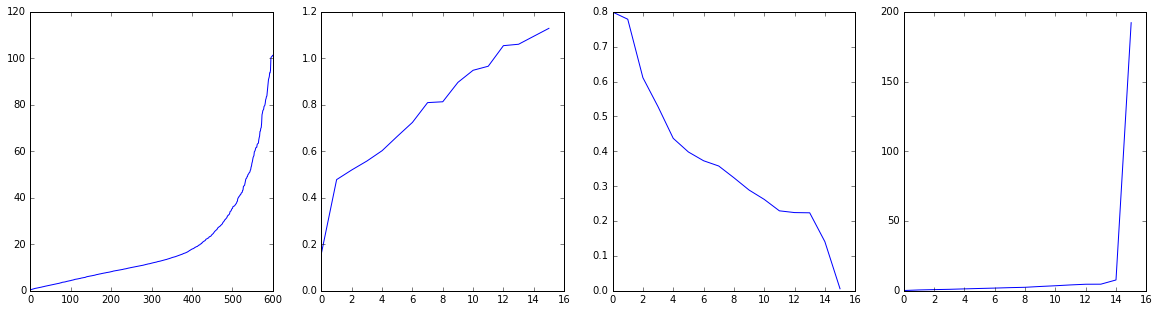

In [13]:
ys = np.asarray(stats['y'])
y_avg = np.flipud(np.sort(np.absolute(ys[-20:].mean(axis=0))))
ratio = s[:ny]/y_avg
fig = plt.figure(figsize=(20,5))
fig.add_subplot(141).plot(s[:600])
fig.add_subplot(142).plot(s[:ny])
fig.add_subplot(143).plot(y_avg)
fig.add_subplot(144).plot(ratio)

Plotted above are the eigenvalues of $C$ and the hidden layer activations for last 20 recorded samples during training. The values are approximatly proportional up to the 11th component. 